In [1]:
# Import relevant modules
import sys, scanpy as sc, anndata, numpy as np, pandas as pd, os
import cell2location, scvi, matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

Global seed set to 0


In [ ]:
# Read Command Line Arguments
# Format: ref_obj, output_folder, sample_id
ref_obj, out_path, sample_id = sys.argv[1:]
ref_obj = os.path.expanduser(ref_obj)
out_path = os.path.expanduser(out_path)

In [18]:
# Read annotated integrated snRNA-seq h5ad into scanpy AnnData object
rna_data = sc.read(ref_obj)
# Raw slot redundant to X
del rna_data.raw

(20093, 28255)


/nobackup/dwzj28/tmp/ipykernel_626940/1737136734.py:13: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rna_data.var["n_cells"] = (rna_data.X.toarray() > 0).sum(axis = 0)


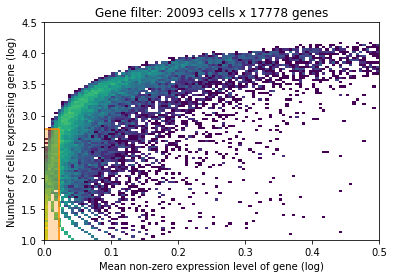

(20093, 17778)


In [19]:
# Filter reference data (scanpy PreProcessing)
print(rna_data.shape)
# Filter cells and genes for entirely empty entries
sc.pp.filter_cells(rna_data, min_genes = 1)
sc.pp.filter_genes(rna_data, min_cells = 1)

# Separate MT genes from GCM
rna_data.var["MT_feat"] = [feat.startswith("MT-") for feat in rna_data.var_names]
rna_data.obsm["MT"] = rna_data[:, rna_data.var["MT_feat"].values].X.toarray()
rna_data = rna_data[:, ~rna_data.var["MT_feat"].values]

# Calculate feature-wise qc statistics
rna_data.var["n_cells"] = (rna_data.X.toarray() > 0).sum(axis = 0)
rna_data.var["mean_nzero"] = (rna_data.X.toarray().sum(axis = 0))/rna_data.var["n_cells"]
rna_data.var["SYMBOL"] = rna_data.var_names

# Perform "permisive gene selection" for widely/highly expressed genes
mean_gene_thresh = np.exp(5e-2)
cell_count_thresh1 = np.log10(rna_data.n_obs * 5e-4)
cell_perc_thresh2 = 3e-2

from cell2location.utils.filtering import filter_genes
permitted_genes = filter_genes(rna_data,
                               cell_count_cutoff = cell_count_thresh1,
                               cell_percentage_cutoff2 = cell_perc_thresh2,
                               nonz_mean_cutoff = mean_gene_thresh)

rna_data = rna_data[:, permitted_genes]

print(rna_data.shape)

In [22]:
# Prepare reference data for regression model
cell2location.models.RegressionModel.setup_anndata(adata = rna_data,
                                                  batch_key = "orig.ident",
                                                  labels_key = "cell_type")

NB_model = cell2location.models.RegressionModel(rna_data)

# View model parameters to verify correct setup
NB_model.view_anndata_setup()

/home/dwzj28/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/cell2location/models/reference/_reference_model.py:112: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype("int64")
/home/dwzj28/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/data/_utils.py:114: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


Anndata setup with scvi-tools version 0.17.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 17778 │
│         n_cells          │ 20093 │
│         n_batch          │  27   │
│         n_labels         │  11   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │   CK158    │          0          │
│                         │   CK159    │          1          │
│                         │   CK160    │          2          │
│                         │   CK162    │          3          │
│                         │   CK163    │          4          │
│                         │   CK164    │          5          │
│                         │   CK165    │          6          │
│                         │   CK356    │          7          │
│                         │   CK357    │          8          │
│                         │   CK358    │          9          │
│                         │   CK359    │         10          │
│                         │   CK360    │         11          │
│                         │   CK361    │         12          │
│                         │   CK362    │         13          │
│                         │   CK363    │         14          │
│                         │   CK364    │         15          │
│                         │   CK365    │         16          │
│                         │   CK366    │         17          │
│                         │   CK367    │         18          │
│                         │   CK368    │         19          │
│                         │   CK370    │         20          │
│                         │   CK371    │         21          │
│                         │   CK372    │         22          │
│                         │   CK373    │         23          │
│                         │   CK374    │         24          │
│                         │   CK375    │         25          │
│                         │   CK376    │         26          │
└─────────────────────────┴────────────┴─────────────────────┘

                                   labels State Registry                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃                Categories                ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │   regular ventricular cardiac myocyte    │          0          │
│                        │                macrophage                │          1          │
│                        │                fibroblast                │          2          │
│                        │        endothelial cell of artery        │          3          │
│                        │        capillary endothelial cell        │          4          │
│                        │          vein endothelial cell           │          5          │
│                        │               neural cell                │          6          │
│                        │ CD8-positive alpha-beta cytotoxic T cell │          7          │
│                        │              pericyte cell               │          8          │
│                        │            smooth muscle cell            │          9          │
│                        │              dendritic cell              │         10          │
└────────────────────────┴──────────────────────────────────────────┴─────────────────────┘

In [66]:
torch.set_num_threads(1)

In [67]:
NB_model.train(max_epochs = 1, batch_size = 1024, lr = 0.01)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dwzj28/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Epoch 1/1: 100%|██████████| 1/1 [01:05<00:00, 65.61s/it, v_num=1, elbo_train=1.28e+8]


In [49]:
# Sample the Bayesian Posterior Distribution of the NB Regression to 
# generate cell type specific feature statistics
rna_data = NB_model.export_posterior(rna_data, 
                                     sample_kwargs = {"num_samples":1000,
                                                      "batch_size":1024})

# Results are stored in varm
# rna_data.varm["means_per_cluster_mu_fg"]

Sampling global variables, sample:  20%|█▉        | 198/999 [00:11<00:46, 17.35it/s]


KeyboardInterrupt: 

In [60]:
# Save NB model and AnnData object containing results
NB_model.save(out_path+"NB_models",prefix = sample_id + "_NB_", overwrite = True)
rna_data.write(out_path+sample_id+"_NB_results.h5ad")